In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import random


In [85]:
# checking availability of GPU
print(torch.cuda.is_available())
torch.cuda.get_device_name(0)

True


'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [86]:
# load the data
input = np.load('random/input_correct.npy')
label = np.load('random/label_correct.npy')

In [87]:
# extract target
rv_label = label[:, 1, :]
times = label[:, 0, :]

In [88]:
# getting residual CCF
# calculate mean CCF plot for each star
mean_ccf_per_star = np.mean(input, axis=1)
# subtract mean CCF plot from each observation
residual_ccf = input - mean_ccf_per_star[:, np.newaxis, :]  # Shape: (10000, 20, 121)
residual_ccf.shape

(10000, 20, 121)

Train/Validation/Train split 70/20/10

In [89]:
# Split data into train (70%), validation (20%), and test (10%) sets
random.seed(123)
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Flatten the indices
total_size = len(residual_ccf)
indices = list(range(total_size))

# Split indices for train and temp (val + test)
train_indices, temp_indices = train_test_split(indices, train_size=train_size)

# Split temp indices for validation and test
val_indices, test_indices = train_test_split(temp_indices, test_size=test_size / (val_size + test_size))

Input data standartization

In [90]:
# Standardization along axis representing data points within each CCF plot (axis=2)
# axis 0 - standardization along all stars, axis 1 - standardization along all observations for each stars
# note: we only use data from train sample for calculating mean and std and then apply transformation for all data
mean_val = np.mean(residual_ccf[train_indices], axis=(0, 1), keepdims=True)
std_val = np.std(residual_ccf[train_indices], axis=(0, 1), keepdims=True)
standardized_residual_ccf = (residual_ccf - mean_val) / std_val
standardized_residual_ccf.shape

(10000, 20, 121)

Now we would fit CNN model

In [91]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten() # Output size 64 * 28 = 1792
        self.fc1 = nn.Linear(64 * 28, 64)
        self.fc2 = nn.Linear(64, 1)  # Output layer with single unit for RV prediction

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Instantiate the model
cnn_model = CNN()
cnn_model.cuda()

# Print the model summary
print(cnn_model)

CNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1792, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


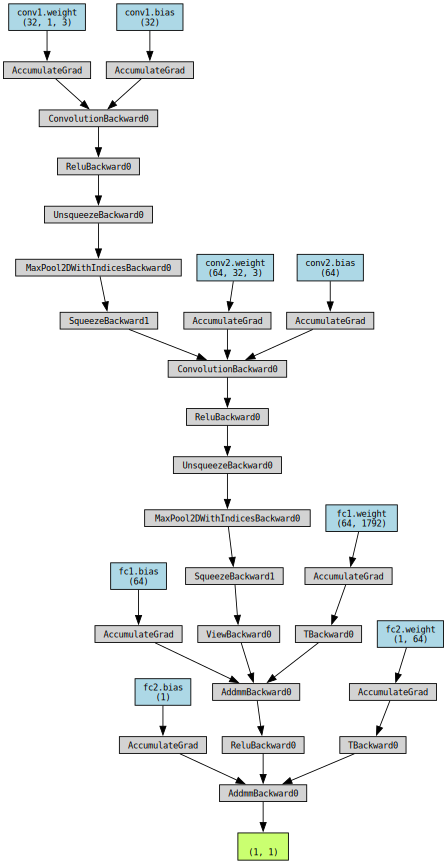

In [92]:
# here we are getting visualization of CNN model
x = torch.randn(1, 1, 121).cuda()
y = cnn_model(x)

torch.onnx.export(cnn_model, x, "cnn_model.onnx", verbose=True) # use this to put into https://netron.app/ and get nice visualization
make_dot(y, params=dict(cnn_model.named_parameters())) # get visualization below 

In [93]:
# for fiting CNN model we use each CNN as a single input, so we reshape data
# Convert data to PyTorch tensors
X_train_cnn_tensor = torch.tensor(standardized_residual_ccf[train_indices].reshape(-1, 121), dtype=torch.float32).cuda()
y_train_cnn_tensor = torch.tensor(rv_label[train_indices].flatten(), dtype=torch.float32).cuda()
X_val_cnn_tensor = torch.tensor(standardized_residual_ccf[val_indices].reshape(-1, 121), dtype=torch.float32).cuda()
y_val_cnn_tensor = torch.tensor(rv_label[val_indices].flatten(), dtype=torch.float32).cuda()
X_test_cnn_tensor = torch.tensor(standardized_residual_ccf[test_indices].reshape(-1, 121), dtype=torch.float32).cuda()
y_test_cnn_tensor = torch.tensor(rv_label[test_indices].flatten(), dtype=torch.float32).cuda()

# Create DataLoader for training and validation data
train_dataset_cnn = TensorDataset(X_train_cnn_tensor, y_train_cnn_tensor)
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
val_dataset_cnn = TensorDataset(X_val_cnn_tensor, y_val_cnn_tensor)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=32)

In [94]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters())

# Training loop
num_epochs = 20
train_losses_cnn = []
val_losses_cnn = []

for epoch in range(num_epochs):
    cnn_model.train()
    train_loss = 0.0
    for inputs, labels in train_loader_cnn:
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = cnn_model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader_cnn.dataset)
    train_losses_cnn.append(train_loss)

    cnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader_cnn:
            outputs = cnn_model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader_cnn.dataset)
    val_losses_cnn.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/20], Train Loss: 59.1579, Val Loss: 44.4484
Epoch [2/20], Train Loss: 36.9823, Val Loss: 38.4290
Epoch [3/20], Train Loss: 32.2797, Val Loss: 32.4092
Epoch [4/20], Train Loss: 29.1678, Val Loss: 29.9500
Epoch [5/20], Train Loss: 26.7857, Val Loss: 27.3262
Epoch [6/20], Train Loss: 25.2204, Val Loss: 28.9123
Epoch [7/20], Train Loss: 23.9272, Val Loss: 24.0933
Epoch [8/20], Train Loss: 22.8431, Val Loss: 24.5915
Epoch [9/20], Train Loss: 21.9806, Val Loss: 23.4426
Epoch [10/20], Train Loss: 21.2432, Val Loss: 24.0935
Epoch [11/20], Train Loss: 20.6576, Val Loss: 22.3174
Epoch [12/20], Train Loss: 19.9806, Val Loss: 22.2837
Epoch [13/20], Train Loss: 19.4500, Val Loss: 20.8061
Epoch [14/20], Train Loss: 19.0577, Val Loss: 22.1704
Epoch [15/20], Train Loss: 18.6617, Val Loss: 20.2860
Epoch [16/20], Train Loss: 18.1465, Val Loss: 20.7491
Epoch [17/20], Train Loss: 17.7828, Val Loss: 22.7460
Epoch [18/20], Train Loss: 17.5156, Val Loss: 19.0909
Epoch [19/20], Train Loss: 17.1707, V

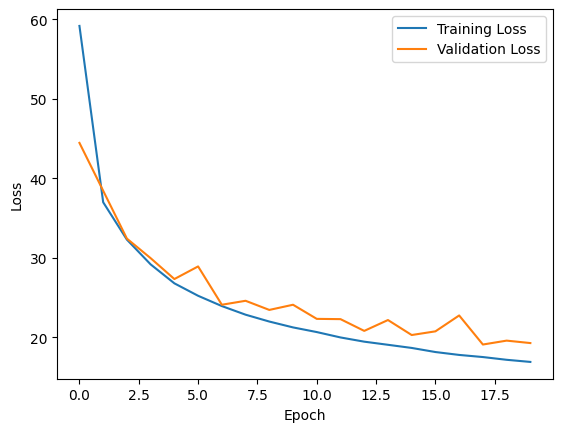

In [95]:
# Plot training and validation loss
plt.plot(train_losses_cnn, label='Training Loss')
plt.plot(val_losses_cnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [96]:
# Evaluate the model on test data
cnn_model.eval()
with torch.no_grad():
    y_pred_tensor = cnn_model(X_test_cnn_tensor.unsqueeze(1))
    test_loss_cnn = criterion(y_pred_tensor, y_test_cnn_tensor.unsqueeze(1))
    y_pred_cnn = y_pred_tensor.cpu().numpy()

print("Test Loss:", test_loss_cnn.item())

Test Loss: 19.1001033782959


In [97]:
# Calculate evaluation metrics
y_test_cnn = rv_label[test_indices].flatten()
mae = mean_absolute_error(y_test_cnn, y_pred_cnn)
mse = mean_squared_error(y_test_cnn, y_pred_cnn)
rmse = root_mean_squared_error(y_test_cnn, y_pred_cnn)
r2 = r2_score(y_test_cnn, y_pred_cnn)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score (R2):", r2)

Mean Absolute Error (MAE): 3.113047230682256
Mean Squared Error (MSE): 19.100103516438846
Root Mean Squared Error (RMSE): 4.370366519691323
R-squared Score (R2): 0.9882061428997364


Text(0, 0.5, 'Predicted RV')

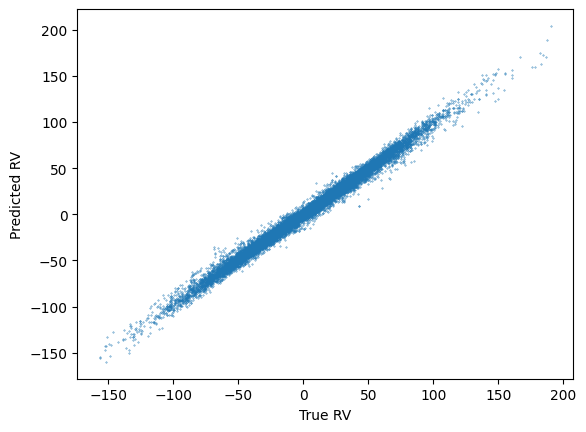

In [98]:
plt.scatter(y_test_cnn, y_pred_cnn, s=0.1)
plt.xlabel('True RV')
plt.ylabel('Predicted RV')

Text(0, 0.5, 'True - Predicted RV')

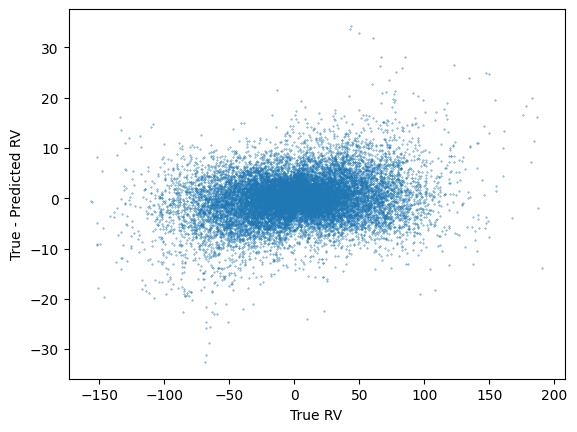

In [99]:
plt.scatter(y_test_cnn, y_test_cnn - y_pred_cnn.flatten(), s=0.1)
plt.xlabel('True RV')
plt.ylabel('True - Predicted RV')

Text(0, 0.5, 'True - Predicted RV')

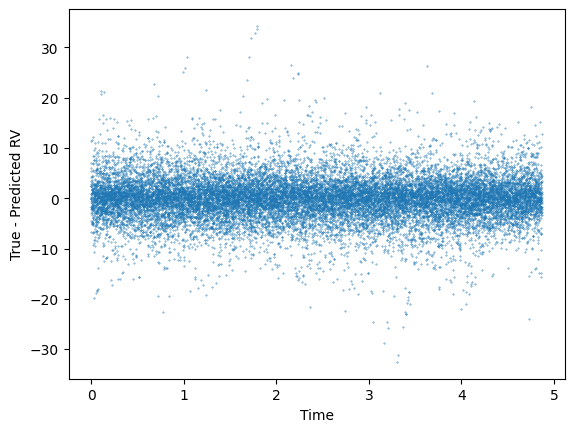

In [100]:
plt.scatter(times[test_indices].flatten(), y_test_cnn - y_pred_cnn.flatten(), s=0.1)
plt.xlabel('Time')
plt.ylabel('True - Predicted RV')

After fitting CNN model we use first part (up to flutten) as an embedding part for future model. So, we create embedding_model with fixed parameters. Input shape 121, output shape 1792

In [101]:
embedding_model = nn.Sequential(
    cnn_model.conv1,
    cnn_model.maxpool1,
    cnn_model.conv2,
    cnn_model.maxpool2,
    cnn_model.flatten
)

# Freeze the parameters of the embedding model
for param in embedding_model.parameters():
    param.requires_grad = False

embedding_model.cuda()

# Print the embedding model
print(embedding_model)

Sequential(
  (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
)


In [102]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super(MultiHeadAttentionBlock, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (num_steps, batch_size, embed_dim)
        attn_output, _ = self.multihead_attn(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.layernorm1(x)
        
        fc_output = self.fc(x)
        x = x + self.dropout(fc_output)
        x = self.layernorm2(x)
        
        return x
    
class RVModelWithAttention(nn.Module):
    def __init__(self, embedding_model, embed_dim, num_heads, dropout=0.1):
        super(RVModelWithAttention, self).__init__()
        self.embedding_model = embedding_model
        self.attention_block = MultiHeadAttentionBlock(embed_dim + 2, num_heads, dropout)
        self.fc1 = nn.Linear(embed_dim + 2, 64)
        self.fc2 = nn.Linear(64, 1)
    
    
    def forward(self, ccf_data, time_sin, time_cos):
        batch_size, num_steps, _ = ccf_data.shape
        
        # Embed CCF data
        ccf_data = ccf_data.view(batch_size * num_steps, 1, -1)
        embeddings = self.embedding_model(ccf_data)
        embeddings = embeddings.view(batch_size, num_steps, -1)

        # Combine embeddings with time features
        time_features = torch.stack((time_sin, time_cos), dim=-1)
        time_features = time_features.view(batch_size, num_steps, -1)
        combined_features = torch.cat((embeddings, time_features), dim=-1)

        # Apply attention block
        combined_features = combined_features.permute(1, 0, 2)  # Convert to (num_steps, batch_size, embed_dim)
        combined_features = self.attention_block(combined_features)
        combined_features = combined_features.permute(1, 0, 2)  # Convert back to (batch_size, num_steps, embed_dim)

        # Fully connected layers for RV prediction
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)
        
        return x.squeeze(-1)


Time encoding

In [103]:
rotation_period = 4.8696
times_sin = np.sin(2 * np.pi / rotation_period * times)
times_cos = np.cos(2 * np.pi / rotation_period * times)
print(times_sin.shape, times_cos.shape)

(10000, 20) (10000, 20)


Standartization of target

In [104]:
mean_train_rv = rv_label[train_indices].mean()
std_train_rv = rv_label[train_indices].std()
print(mean_train_rv, std_train_rv)
rv_norm = (rv_label - mean_train_rv) / std_train_rv

1.0422504236846764 39.55063814453704


In [128]:
# here we calculate RMSE if we predict mean train RV for all test dataset
root_mean_squared_error(rv_label[test_indices].flatten(), np.full_like(rv_label[test_indices].flatten(), mean_train_rv))

40.242967676668066

In [105]:
# Function to create TensorDataset and DataLoader from indices
def create_dataloader(indices, batch_size, times_sin, times_cos):
    ccf_data_subset = standardized_residual_ccf[indices]
    time_sin_subset = times_sin[indices]
    time_cos_subset = times_cos[indices]
    rv_labels_subset = rv_norm[indices]
    # rv_labels_subset = rv_label[indices]
    
    ccf_data_tensor = torch.tensor(ccf_data_subset, dtype=torch.float32).cuda()
    time_sin_tensor = torch.tensor(time_sin_subset, dtype=torch.float32).cuda()
    time_cos_tensor = torch.tensor(time_cos_subset, dtype=torch.float32).cuda()
    rv_labels_tensor = torch.tensor(rv_labels_subset, dtype=torch.float32).cuda()
    
    dataset = TensorDataset(ccf_data_tensor, time_sin_tensor, time_cos_tensor, rv_labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [106]:
batch_size = 32

train_loader = create_dataloader(train_indices, batch_size, times_sin, times_cos)
val_loader = create_dataloader(val_indices, batch_size, times_sin, times_cos)
test_loader = create_dataloader(test_indices, batch_size, times_sin, times_cos)

In [107]:
# Instantiate the model with attention
embed_dim = 1792  # Output size of the embedding model
num_heads = 6
learning_rate = 0.0001
dropout_rate = 0.15
model = RVModelWithAttention(embedding_model, embed_dim, num_heads, dropout_rate)
model.cuda()

# Reinitialize optimizer with the new model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
criterion = nn.MSELoss()

# Training loop with validation
num_epochs = 25
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for ccf_batch, sin_batch, cos_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(ccf_batch, sin_batch, cos_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * ccf_batch.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset) * (std_train_rv ** 2)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for ccf_batch, sin_batch, cos_batch, labels_batch in val_loader:
            outputs = model(ccf_batch, sin_batch, cos_batch)
            loss = criterion(outputs, labels_batch)
            running_val_loss += loss.item() * ccf_batch.size(0)
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset) * (std_train_rv ** 2)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
    
    # Save the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_rv_prediction_model.pth')

print("Training completed.")

Epoch [1/25], Train Loss: 92.0361, Validation Loss: 22.7280
Epoch [2/25], Train Loss: 12.3158, Validation Loss: 8.3639
Epoch [3/25], Train Loss: 7.2590, Validation Loss: 4.2828
Epoch [4/25], Train Loss: 5.2852, Validation Loss: 3.5808
Epoch [5/25], Train Loss: 4.8661, Validation Loss: 2.1860
Epoch [6/25], Train Loss: 3.8473, Validation Loss: 4.9380
Epoch [7/25], Train Loss: 3.2405, Validation Loss: 3.5086
Epoch [8/25], Train Loss: 2.8634, Validation Loss: 2.1018
Epoch [9/25], Train Loss: 2.6503, Validation Loss: 1.6250
Epoch [10/25], Train Loss: 2.2464, Validation Loss: 1.3505
Epoch [11/25], Train Loss: 2.4778, Validation Loss: 1.7307
Epoch [12/25], Train Loss: 2.1024, Validation Loss: 1.8300
Epoch [13/25], Train Loss: 2.4441, Validation Loss: 1.8093
Epoch [14/25], Train Loss: 2.3076, Validation Loss: 1.5292
Epoch [15/25], Train Loss: 1.9095, Validation Loss: 1.2674
Epoch [16/25], Train Loss: 2.0813, Validation Loss: 0.9718
Epoch [17/25], Train Loss: 1.9932, Validation Loss: 2.6934
Epo

In [119]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_rv_prediction_model.pth'))

# Evaluate on the test set
model.eval()
y_pred_tr = []
y_true_tr = []
running_test_loss = 0.0
with torch.no_grad():
    for ccf_batch, sin_batch, cos_batch, labels_batch in test_loader:
        ccf_batch = ccf_batch.cuda()
        sin_batch = sin_batch.cuda()
        cos_batch = cos_batch.cuda()
        labels_batch = labels_batch.cuda()
        outputs = model(ccf_batch, sin_batch, cos_batch)
        y_pred_tr.extend(outputs.flatten().tolist())
        y_true_tr.extend(labels_batch.flatten().tolist())
        squared_diff = np.array(outputs.cpu() - labels_batch.cpu()) ** 2
        loss = criterion(outputs, labels_batch)
        running_test_loss += loss.item() * ccf_batch.size(0)

epoch_test_loss = running_test_loss / len(test_loader.dataset) * (std_train_rv ** 2)
print(f"Test Loss: {epoch_test_loss:.4f}")

Test Loss: 1.0194


In [123]:
# Convert predictions and true values to numpy arrays for metric calculation
y_pred_tr = np.array(y_pred_tr) * std_train_rv + mean_train_rv
y_true_tr = np.array(y_true_tr) * std_train_rv + mean_train_rv

# Calculate evaluation metrics
mae = mean_absolute_error(y_true_tr, y_pred_tr)
mse = mean_squared_error(y_true_tr, y_pred_tr)
rmse = root_mean_squared_error(y_true_tr, y_pred_tr)
r2 = r2_score(y_true_tr, y_pred_tr)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score (R2):", r2)

Mean Absolute Error (MAE): 0.738530589908522
Mean Squared Error (MSE): 1.0193905575683075
Root Mean Squared Error (RMSE): 1.0096487297908652
R-squared Score (R2): 0.9993705507114461


Text(0, 0.5, 'Predicted RV')

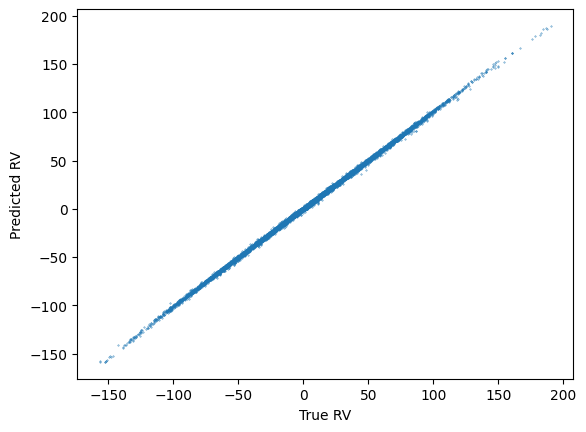

In [111]:
plt.scatter(y_true_tr, y_pred_tr, s=0.1)
plt.xlabel('True RV')
plt.ylabel('Predicted RV')

Text(0, 0.5, 'True - Predicted RV')

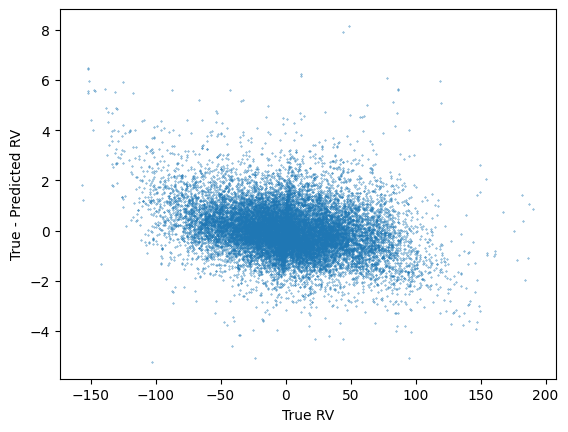

In [112]:
plt.scatter(y_true_tr, y_true_tr - y_pred_tr, s=0.1)
plt.xlabel('True RV')
plt.ylabel('True - Predicted RV')

Text(0, 0.5, 'True - Predicted RV')

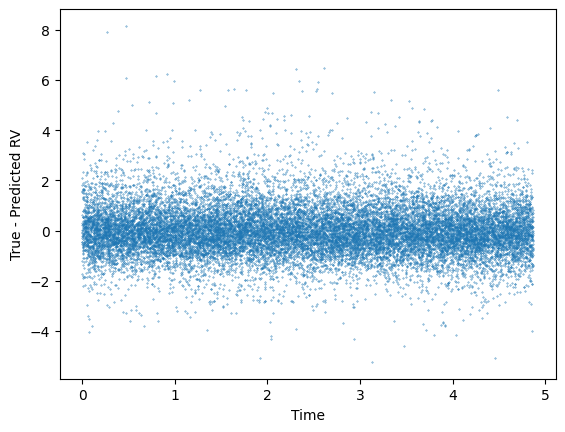

In [113]:
plt.scatter(times[test_indices].flatten(), y_true_tr - y_pred_tr, s=0.1)
plt.xlabel('Time')
plt.ylabel('True - Predicted RV')

Now we can test models with different rotation periods

In [116]:
def test_loss_period(period, model_save, num_epochs=20, batch_size = 32, embed_dim = 1792, num_heads = 6, learning_rate = 0.0001, dropout_rate = 0.15):
    
    times_sin_p = np.sin(2 * np.pi / period * times)
    times_cos_p = np.cos(2 * np.pi / period * times)
    train_loader = create_dataloader(train_indices, batch_size, times_sin_p, times_cos_p)
    val_loader = create_dataloader(val_indices, batch_size, times_sin_p, times_cos_p)
    test_loader = create_dataloader(test_indices, batch_size, times_sin_p, times_cos_p)

    model = RVModelWithAttention(embedding_model, embed_dim, num_heads, dropout_rate)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase 
        model.train()
        running_loss = 0.0
        for ccf_batch, sin_batch, cos_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(ccf_batch, sin_batch, cos_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * ccf_batch.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset) * (std_train_rv ** 2)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for ccf_batch, sin_batch, cos_batch, labels_batch in val_loader:
                outputs = model(ccf_batch, sin_batch, cos_batch)
                loss = criterion(outputs, labels_batch)
                running_val_loss += loss.item() * ccf_batch.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset) * (std_train_rv ** 2)
        
        # print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
        
        # Save the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), model_save)

    model.load_state_dict(torch.load(model_save))

    # Evaluate on the test set
    model.eval()
    y_pred = []
    y_true = []
    running_test_loss = 0.0
    with torch.no_grad():
        for ccf_batch, sin_batch, cos_batch, labels_batch in test_loader:
            ccf_batch = ccf_batch.cuda()
            sin_batch = sin_batch.cuda()
            cos_batch = cos_batch.cuda()
            labels_batch = labels_batch.cuda()
            outputs = model(ccf_batch, sin_batch, cos_batch)
            y_pred.extend(outputs.flatten().tolist())
            y_true.extend(labels_batch.flatten().tolist())
            loss = criterion(outputs, labels_batch)
            running_test_loss += loss.item() * ccf_batch.size(0)

    epoch_test_loss = running_test_loss / len(test_loader.dataset) * (std_train_rv ** 2)
    # print(f"Test Loss: {epoch_test_loss:.4f}")

    y_pred = np.array(y_pred) * std_train_rv + mean_train_rv
    y_true = np.array(y_true) * std_train_rv + mean_train_rv
    
    return y_pred, y_true, epoch_test_loss


In [ ]:
periods = [2.9687, 3.5273, 4.8696, 5.3217, 6.1934, 10000]
pred_ys = []
true_ys = [] 
mses = []
for p in periods:
    pred_y, true_y, test_mse = test_loss_period(p, f'period_{p}.pth')
    print("period", p, "mse", test_mse)
    pred_ys.append(pred_y)
    true_ys.append(true_ys)
    mses.append(test_mse)
mses

In [135]:
print("large period", periods[-1], "mse", mses[-1])

large period 10000 mse 1.3059796413297156


In [124]:
mses[2] = epoch_test_loss
pred_ys[2] = y_pred_tr
true_ys[2] = y_true_tr

Text(0, 0.5, 'MSE')

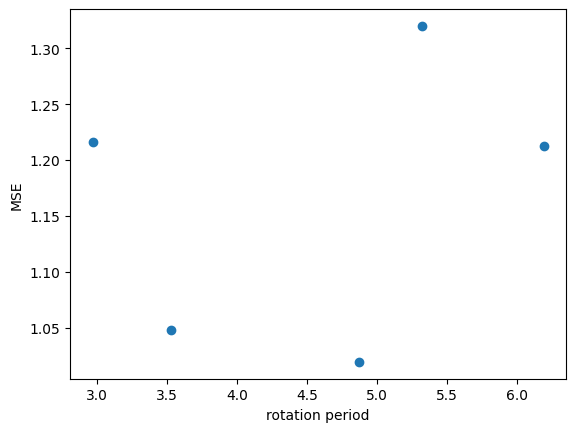

In [134]:
plt.scatter(periods[:-1], mses[:-1])
plt.xlabel("rotation period")
plt.ylabel("MSE")

Text(0, 0.5, 'RMSE')

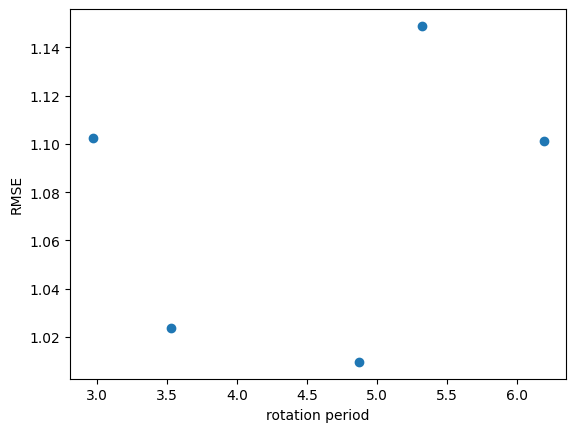

In [133]:
plt.scatter(periods[:-1], np.sqrt(mses[:-1]))
plt.xlabel("rotation period")
plt.ylabel("RMSE")